## SVM

In [5]:
import pandas as pd

df = pd.read_csv('mbti.csv', index_col=None) 
# df = pd.read_excel(open('mbti.xlsx', 'rb'),sheet_name='mbti') 
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


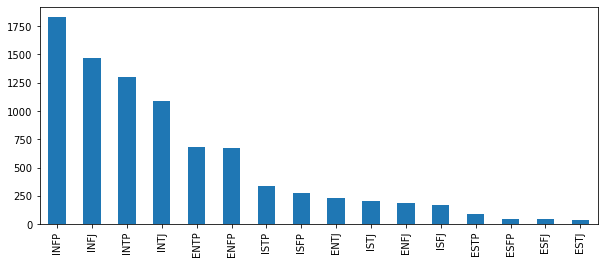

In [6]:
# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,4))
df["type"].value_counts().plot(kind='bar');

In [7]:
import nltk
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

nltk.download('stopwords')


REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|')
URL_RE = re.compile('(\w+:\/\/\S+)|^rt|http.+?')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() 
    text = text.replace("|||"," ")
    # text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    # text = BAD_SYMBOLS_RE.sub('', text) 
    # text = URL_RE.sub('urladd',text)
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df['posts'] = df['posts'].apply(clean_text)
df

,type,posts
0,INFJ,enfp intj moments sportscenter top ten plays p...
1,ENTP,finding lack posts alarming sex boring positio...
2,INTP,good one course say know blessing curse absolu...
3,INTJ,dear intp enjoyed conversation day esoteric ga...
4,ENTJ,fired another silly misconception approaching ...
...,...,...
8670,ISFP,ixfp always think cats fi doms reason especial...
8671,ENFP,thread already exists someplace else heck dele...
8672,INTP,many questions things would take purple pill p...
8673,INFP,conflicted right comes wanting children honest...


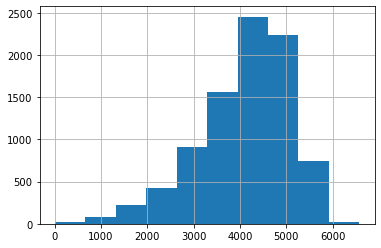

count    8675.000000
mean     4105.071931
std       981.542474
min         5.000000
25%      3554.000000
50%      4273.000000
75%      4824.000000
max      6574.000000
dtype: float64

In [9]:
posts_len = [len(x) for x in df.posts]
pd.Series(posts_len).hist()
plt.show()
pd.Series(posts_len).describe()

In [11]:
!pip install gensim

     |████████████████████████████████| 24.1 MB 9.6 MB/s eta 0:00:01              | 706 kB 9.6 MB/s eta 0:00:03MB/s eta 0:00:01███████████████████████▌      | 19.2 MB 9.6 MB/s eta 0:00:01�██▋| 23.7 MB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 6.8 MB/s  eta 0:00:01


In [12]:
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument
def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.posts, df["type"], random_state=10, 
                                                    test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [14]:
from gensim.models import doc2vec
from tqdm import tqdm
vector_size = 300
model_dbow = doc2vec.Doc2Vec(dm=0, vector_size=vector_size, negative=5, min_count=1, alpha=0.065, 
                     min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 8675/8675 [00:00<00:00, 2490798.69it/s]


In [15]:
from sklearn import utils
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), 
                     total_examples=len(all_data), 
                     epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 8675/8675 [00:00<00:00, 3472238.50it/s]


In [16]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [17]:
import numpy as np
train_vectors_dbow = get_vectors(model_dbow, len(X_train), vector_size, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), vector_size, 'Test')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  """


In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
model = SVC(C=10, gamma='auto', kernel='rbf')
model.fit(train_vectors_dbow, y_train)
y_pred = model.predict(test_vectors_dbow)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5816365731847868
              precision    recall  f1-score   support

        ENFJ       0.28      0.23      0.26        47
        ENFP       0.54      0.64      0.59       193
        ENTJ       0.42      0.34      0.38        83
        ENTP       0.50      0.58      0.54       190
        ESFJ       1.00      0.07      0.12        15
        ESFP       0.17      0.07      0.10        15
        ESTJ       0.00      0.00      0.00        14
        ESTP       0.64      0.27      0.38        26
        INFJ       0.58      0.67      0.62       435
        INFP       0.65      0.72      0.69       559
        INTJ       0.58      0.58      0.58       337
        INTP       0.60      0.65      0.62       379
        ISFJ       0.71      0.32      0.44        47
        ISFP       0.47      0.26      0.34        88
        ISTJ       0.54      0.32      0.40        60
        ISTP       0.65      0.34      0.45       115

    accuracy                           0.58      260

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LSTM

https://www.kaggle.com/arunmohan003/sentiment-analysis-using-lstm-pytorch

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
df = pd.read_csv('mbti.csv', index_col=None) 
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [4]:
nltk.download('stopwords')


REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|')
URL_RE = re.compile('(\w+:\/\/\S+)|^rt|http.+?')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() 
    text = text.replace("|||"," ")
    # text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    # text = BAD_SYMBOLS_RE.sub('', text) 
    # text = URL_RE.sub('urladd',text)
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df['posts'] = df['posts'].apply(clean_text)
df

,type,posts
0,INFJ,enfp intj moments sportscenter top ten plays p...
1,ENTP,finding lack posts alarming sex boring positio...
2,INTP,good one course say know blessing curse absolu...
3,INTJ,dear intp enjoyed conversation day esoteric ga...
4,ENTJ,fired another silly misconception approaching ...
...,...,...
8670,ISFP,ixfp always think cats fi doms reason especial...
8671,ENFP,thread already exists someplace else heck dele...
8672,INTP,many questions things would take purple pill p...
8673,INFP,conflicted right comes wanting children honest...


In [6]:
def clean_label(label):
  if label=="ENFJ":
    return 0
  elif label=="ENFP":
    return 1
  elif label=="ENTJ":
    return 2
  elif label=="ENTP":
    return 3
  elif label=="ESFJ":
    return 4
  elif label=="ESFP":
    return 5
  elif label=="ESTJ":
    return 6 
  elif label=="ESTP":
    return 7
  elif label=="ISFP":
    return 8
  elif label=="INFP":
    return 9
  elif label=="INTJ":
    return 10
  elif label=="INTP":
    return 11
  elif label=="ISFJ":
    return 12
  elif label=="ISFP":
    return 13
  elif label=="ISTJ":
    return 14
  elif label=="ISTP":
    return 15
  elif label=="INFJ":
    return 16
  else:
    return label

In [7]:
df['type'] = df['type'].apply(clean_label)
df['type'] 

0       16
1        3
2       11
3       10
4        2
        ..
8670     8
8671     1
8672    11
8673     9
8674     9
Name: type, Length: 8675, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df["posts"], df["type"], random_state=10, 
                                                    test_size=0.2, stratify = df["type"] )

In [9]:
def tockenize(x_train,y_train,x_test,y_test):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.split():
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words (2000) 
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:2000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[word] for word in sent.split() 
                                     if word in onehot_dict.keys()])
    for sent in x_test:
            final_list_test.append([onehot_dict[word] for word in sent.split() 
                                    if word in onehot_dict.keys()])
            
    encoded_train = [label for label in y_train]  
    encoded_test = [label for label in y_test] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [10]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

In [11]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 2000


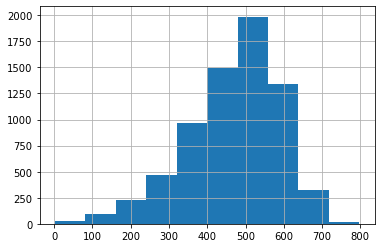

count    6940.000000
mean      469.041643
std       120.767994
min         2.000000
25%       397.000000
50%       488.000000
75%       556.000000
max       797.000000
dtype: float64

In [12]:
post_len = [len(i) for i in x_train]
pd.Series(post_len).hist()
plt.show()
pd.Series(post_len).describe()

In [59]:
def padding_(sentences, seq_len):
    length = []
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for index, post in enumerate(sentences):
        if len(post) != 0:
            length.append(len(post))
            features[index, -len(post):] = np.array(post)[:seq_len]
    return features,np.array(length)

In [60]:
import torch
seq_len = 500
x_train_pad, x_train_length = padding_(x_train,seq_len)
x_test_pad, x_test_length = padding_(x_test,seq_len)

In [61]:
print(x_train_pad)

[[  50    4   94 ...  628   12   74]
 [   0    0    0 ...   12 1588   48]
 [ 461  289   11 ...  839  568  570]
 ...
 [   0    0    0 ...  460  792 1189]
 [  35  496  126 ...    3  176    3]
 [   0    0    0 ...  100  557 1662]]


In [125]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    offsets = [0]
    for (_post, _label, _length) in batch:
#         print("label: ",_label)
#         print("text: ",_post)
#         print("length: ",_length)
        label_list.append(_label)
        text_list.append(_post)
        lengths.append(_length)
        offsets.append(seq_len)
    # label must be in the same size as target
    label_list = torch.tensor(label_list,dtype=torch.float).cumsum(dim=0)
    lengths = torch.tensor(lengths).cumsum(dim=0)
    text_list = torch.cat(text_list)
#     print("text list size: ",text_list.size())
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    return text_list.to(device), label_list.to(device), lengths.to(device)

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad).to(device), torch.from_numpy(y_train).to(device),torch.from_numpy(x_train_length).to(device))
test_data = TensorDataset(torch.from_numpy(x_test_pad).to(device), torch.from_numpy(y_test).to(device),torch.from_numpy(x_test_length).to(device))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, collate_fn=collate_batch)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, collate_fn=collate_batch)

In [ ]:
# logistic model
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LogisticRegression(nn.Module):
    def __init__(self, vocab, embed_dim):
        super().__init__()
        # embeddingbag outputs the average of all the words in a sentence
        self.embedding = nn.Embedding(len(vocab)+1, embed_dim)
        self.fc = nn.Linear(embed_dim, 1)
        self._init_weights()

    def _init_weights(self):
        """Initialize network parameters 
        """
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, lengths):
        offsets =  [i for i in range()]
        embedded = self.embedding(text) # (batch_size, sent_len, emb_size)
        embedded = embedded.sum(dim = 1) / lengths[:, None] # (add one axis)
        return torch.sigmoid(self.fc(embedded))

class LSTMcustom(nn.Module):
    def __init__(self, vocab, embed_dim):
        super().__init__()
        self.sent_len = len(vocab)+1
        self.embed_dim = embed_dim
        # embeddingbag outputs the average of all the words in a sentence
        self.embedding = nn.Embedding(self.sent_len, embed_dim)
        # Initialize LSTM model. The arguments are in this order input_dim, hidden_dim, n_layers
        self.lstm = nn.LSTM(embed_dim, 256, 1, bidirectional=False, batch_first = True)
        
        # # Q1: What should be the input dimension of this linear layer?
        self.fc = nn.Linear(256, 1)
        # test accuracy: 63.93%
        
    def forward(self, text, lengths):
        embedded = self.embedding(text) # (batch_size, sent_len, emb_size)
#         embedded = embedded.view(len(embedded), 1, -1)
        embedded = embedded.view(len(lengths),500, self.embed_dim)
        lstm_out,_ = self.lstm(embedded) # lstm_out is a 3d tensor (batch_size, sent_len, output_size). If you have a bidirectional LSTM, the outputsize will be 2*output_size
        
#         # Q3: Select the hidden output of the last element in the sequence. Hint: Remember that you padded the sequence and you already know the length of the sequence.
#         batch_size = lstm_out.size()[0]
#         last_indices = []
#         for length in lengths:
#             last_indices.append(int(length)-1)
#         last_indices = torch.LongTensor(last_indices)
#         rows = torch.arange(0, batch_size).long()
        lstm_out = lstm_out[:, -1, :]
#         lstm_out_temp = []
#         for index,length in enumerate(lengths):
#             lstm_out_temp.append(lstm_out[index,int(length)-1,:])
#         lstm_out = torch.stack(lstm_out_temp)
        return torch.sigmoid(self.fc(lstm_out))  

In [ ]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 50
    start_time = time.time()

    for idx, (text, label, lengths) in enumerate(dataloader):
        optimizer.zero_grad()
        # forward propagation
        predicted_label = model(text, lengths)
        # calculate loss and backpropagate to model paramters
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        # update parameters by stepping the optimizer
        optimizer.step()
        total_acc += ((predicted_label > 0.5) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text, label, lengths) in enumerate(dataloader):
            predicted_label = model(text, lengths)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [161]:
# Hyperparameters
EPOCHS = 5 # epoch

model = LSTMcustom(vocab=vocab, embed_dim=100).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()
total_accu = None


for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_loader)

| epoch   1 |    50/  347 batches | accuracy    0.026
| epoch   1 |   100/  347 batches | accuracy    0.023
| epoch   1 |   150/  347 batches | accuracy    0.050
| epoch   1 |   200/  347 batches | accuracy    0.097
| epoch   1 |   250/  347 batches | accuracy    0.044
| epoch   1 |   300/  347 batches | accuracy    0.014
| epoch   2 |    50/  347 batches | accuracy    0.032
| epoch   2 |   100/  347 batches | accuracy    0.066
| epoch   2 |   150/  347 batches | accuracy    0.068
| epoch   2 |   200/  347 batches | accuracy    0.016
| epoch   2 |   250/  347 batches | accuracy    0.009
| epoch   2 |   300/  347 batches | accuracy    0.023
| epoch   3 |    50/  347 batches | accuracy    0.032
| epoch   3 |   100/  347 batches | accuracy    0.064
| epoch   3 |   150/  347 batches | accuracy    0.062
| epoch   3 |   200/  347 batches | accuracy    0.033
| epoch   3 |   250/  347 batches | accuracy    0.067
| epoch   3 |   300/  347 batches | accuracy    0.087
| epoch   4 |    50/  347 ba

In [163]:
accu_test = evaluate(test_loader)
print('test accuracy {:8.5f}%'.format(accu_test))

test accuracy  0.00115%


## K-means clustering

http://brandonrose.org/clustering

https://www.youtube.com/watch?v=ORpDAUQUnkU

In [173]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

In [252]:
df = pd.read_csv('mbti.csv', index_col=None) 
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
type     8675 non-null object
posts    8675 non-null object
dtypes: object(2)
memory usage: 135.7+ KB


In [254]:
nltk.download('stopwords')


REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|')
URL_RE = re.compile('(\w+:\/\/\S+)|^rt|http.+?')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() 
    text = text.replace("|||","\n")
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [255]:
df['posts'] = df['posts'].apply(clean_text)
df

,type,posts
0,INFJ,enfp intj moments sportscenter top ten plays p...
1,ENTP,finding lack posts alarming sex boring positio...
2,INTP,good one course say know blessing curse absolu...
3,INTJ,dear intp enjoyed conversation day esoteric ga...
4,ENTJ,fired another silly misconception approaching ...
...,...,...
8670,ISFP,ixfp always think cats fi doms reason especial...
8671,ENFP,thread already exists someplace else heck dele...
8672,INTP,many questions things would take purple pill p...
8673,INFP,conflicted right comes wanting children honest...


In [256]:
df["EI"] = [row["type"][0] for _,row in df.iterrows()]
df

,type,posts,EI
0,INFJ,enfp intj moments sportscenter top ten plays p...,I
1,ENTP,finding lack posts alarming sex boring positio...,E
2,INTP,good one course say know blessing curse absolu...,I
3,INTJ,dear intp enjoyed conversation day esoteric ga...,I
4,ENTJ,fired another silly misconception approaching ...,E
...,...,...,...
8670,ISFP,ixfp always think cats fi doms reason especial...,I
8671,ENFP,thread already exists someplace else heck dele...,E
8672,INTP,many questions things would take purple pill p...,I
8673,INFP,conflicted right comes wanting children honest...,I


In [257]:
df["NS"] = [row["type"][1] for _,row in df.iterrows()]
df

,type,posts,EI,NS
0,INFJ,enfp intj moments sportscenter top ten plays p...,I,N
1,ENTP,finding lack posts alarming sex boring positio...,E,N
2,INTP,good one course say know blessing curse absolu...,I,N
3,INTJ,dear intp enjoyed conversation day esoteric ga...,I,N
4,ENTJ,fired another silly misconception approaching ...,E,N
...,...,...,...,...
8670,ISFP,ixfp always think cats fi doms reason especial...,I,S
8671,ENFP,thread already exists someplace else heck dele...,E,N
8672,INTP,many questions things would take purple pill p...,I,N
8673,INFP,conflicted right comes wanting children honest...,I,N


In [258]:
df["FT"] = [row["type"][2] for _,row in df.iterrows()]
df

,type,posts,EI,NS,FT
0,INFJ,enfp intj moments sportscenter top ten plays p...,I,N,F
1,ENTP,finding lack posts alarming sex boring positio...,E,N,T
2,INTP,good one course say know blessing curse absolu...,I,N,T
3,INTJ,dear intp enjoyed conversation day esoteric ga...,I,N,T
4,ENTJ,fired another silly misconception approaching ...,E,N,T
...,...,...,...,...,...
8670,ISFP,ixfp always think cats fi doms reason especial...,I,S,F
8671,ENFP,thread already exists someplace else heck dele...,E,N,F
8672,INTP,many questions things would take purple pill p...,I,N,T
8673,INFP,conflicted right comes wanting children honest...,I,N,F


In [283]:
df["PJ"] = [row["type"][3] for _,row in df.iterrows()]
df

,type,posts,EI,NS,FT,PJ,cluster
0,INFJ,enfp intj moments sportscenter top ten plays p...,I,N,F,J,0
1,ENTP,finding lack posts alarming sex boring positio...,E,N,T,P,0
2,INTP,good one course say know blessing curse absolu...,I,N,T,P,0
3,INTJ,dear intp enjoyed conversation day esoteric ga...,I,N,T,J,0
4,ENTJ,fired another silly misconception approaching ...,E,N,T,J,0
...,...,...,...,...,...,...,...
8670,ISFP,ixfp always think cats fi doms reason especial...,I,S,F,P,0
8671,ENFP,thread already exists someplace else heck dele...,E,N,F,P,0
8672,INTP,many questions things would take purple pill p...,I,N,T,P,0
8673,INFP,conflicted right comes wanting children honest...,I,N,F,P,0


In [260]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [261]:
documents = df["posts"].values.astype("U")

In [262]:
vectorizer = TfidfVectorizer(stop_words="english")
features = vectorizer.fit_transform(documents)

In [266]:
k = 2
model = KMeans(n_clusters=k,init="k-means++",max_iter=100,n_init=1)
model.fit(features)

KMeans(max_iter=100, n_clusters=2, n_init=1)

In [267]:
df["cluster"] = model.labels_

In [268]:
df.head()

,type,posts,EI,NS,FT,PJ,cluster
0,INFJ,enfp intj moments sportscenter top ten plays p...,I,N,F,I,0
1,ENTP,finding lack posts alarming sex boring positio...,E,N,T,E,0
2,INTP,good one course say know blessing curse absolu...,I,N,T,I,0
3,INTJ,dear intp enjoyed conversation day esoteric ga...,I,N,T,I,0
4,ENTJ,fired another silly misconception approaching ...,E,N,T,E,0


In [278]:
def calculate_score(column,reverse):
    count = 0
    if(reverse):
        a = column[1]
        b = column[0]
    else:
        a = column[0]
        b = column[1]
    for i,row in df.iterrows():
        if((row[column]==a) and (row.cluster==1)):
            count += 1
        elif((row[column]==b) and (row.cluster==0)):
            count += 1
    return count/(i+1)

In [279]:
def score(column):
    a = calculate_score(column,False)
    b = calculate_score(column,True)
    if(a>b):
        x = column[0]
        y = column[1]
        score = a
    else:
        x = column[1]
        y = column[0]
        score = b
    print(f"accuracy with ({x},{y}) = (1,0): {score}")

In [284]:
score("EI")
score("NS")
score("FT")
score("PJ")

accuracy with (E,I) = (1,0): 0.7636887608069164
accuracy with (S,N) = (1,0): 0.8563688760806917
accuracy with (T,F) = (1,0): 0.5398270893371758
accuracy with (J,P) = (1,0): 0.6026512968299712


## Lexicon Sentiment Analysis (Unsupervised learning)

https://www.kaggle.com/datatattle/lexicon-sentiment-analysis-unsupervised

In [210]:
!pip install wordcloud

     |████████████████████████████████| 366 kB 11.8 MB/s eta 0:00:01


In [211]:
#Loading libraries
import numpy as np # provides a high-performance multidimensional array and tools for its manipulation
import pandas as pd # for data munging, it contains manipulation tools designed to make data analysis fast and easy
import re # Regular Expressions - useful for extracting information from text 
import nltk # Natural Language Tool Kit for symbolic and statistical natural language processing
import spacy # processing and understanding large volumes of text
import string # String module contains some constants, utility function, and classes for string manipulation
import re

# For viz
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None

In [212]:
df = pd.read_csv('mbti.csv', index_col=None) 
df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [ ]:
# There are primarily 3 ways:
# 1) Rule-based methods
# 2) Feature-based methods
# 3) Embedding-based methods

In [213]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 25.4 MB/s eta 0:00:01


In [214]:
import vaderSentiment
# calling SentimentIntensityAnalyzer object
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [216]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
words_descriptions = df['posts'].apply(tokenizer.tokenize)
words_descriptions.head()

0    [http, www, youtube, com, watch, v, qsXHcwe3kr...
1    [I, m, finding, the, lack, of, me, in, these, ...
2    [Good, one, _____, https, www, youtube, com, w...
3    [Dear, INTP, I, enjoyed, our, conversation, th...
4    [You, re, fired, That, s, another, silly, misc...
Name: posts, dtype: object

In [217]:
all_words = [word for tokens in words_descriptions for word in tokens]
df['description_lengths']= [len(tokens) for tokens in words_descriptions]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

11664593 words total, with a vocabulary size of 177653


In [218]:
# Checking most common words
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(100)

[('I', 600859),
 ('to', 301400),
 ('the', 280633),
 ('a', 238597),
 ('and', 230458),
 ('of', 184180),
 ('you', 164009),
 ('it', 150240),
 ('that', 150141),
 ('is', 136883),
 ('in', 123739),
 ('t', 109686),
 ('my', 108681),
 ('s', 106919),
 ('for', 86608),
 ('have', 82603),
 ('with', 81785),
 ('me', 80864),
 ('but', 78916),
 ('m', 77202),
 ('be', 75138),
 ('are', 69465),
 ('like', 66719),
 ('not', 65549),
 ('this', 62903),
 ('on', 61792),
 ('an', 60526),
 ('was', 58387),
 ('as', 55599),
 ('can', 51402),
 ('just', 50331),
 ('or', 50258),
 ('about', 49597),
 ('think', 49358),
 ('so', 48513),
 ('don', 47185),
 ('do', 46833),
 ('people', 44789),
 ('your', 42245),
 ('what', 41810),
 ('at', 39498),
 ('if', 38816),
 ('all', 37887),
 ('know', 36621),
 ('i', 36119),
 ('when', 36097),
 ('they', 35708),
 ('It', 35612),
 ('more', 34493),
 ('really', 34038),
 ('would', 33929),
 ('ve', 33667),
 ('one', 33556),
 ('out', 30876),
 ('get', 30147),
 ('am', 29540),
 ('from', 28814),
 ('we', 28700),
 ('beca